<a href="https://colab.research.google.com/github/ffabi/VisualAnalysis/blob/main/M%C3%A9r%C3%A9si_weather_HF_AEP0TG_OZFKFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Specifikáció

Házi feladat téma (rövid megnevezés) *:

Napelem teljesítményének vizsgálata az időjárás függvényében

Házi feladat leírás (miről szól a feladat) *:

A napelemes rendszerek teljesítménye számtalan tényezőtől függ: panelek száma, alkalmazott technológia és annak hatásfoka, dőlésszög, árnyékolódás, az egyenlítőtől mért távolság, aktuális időjárási jellemzők, stb. Projektünkben egy bizonyos napelemrendszer teljesítményét fogjuk vizsgálni az aktuális időjárás függvényében. A teljesítmény- és időjárásadatokból akár két részletes kimutatást is lehetne készíteni, a napelem esetében a hosszabbtávú trendekről, az időjárás esetében pedig például annak előrejelzéséről. A két adatforrás feldolgozása együtt fog majd teljes képet alkotni, viszont ez a komplexitás esetében több mint kétszeres szorzót jelent, ez az oka a csapatmunkának.

Házi feladatban megválaszolandó kérdések *:

A napelemes rendszerek teljesítménye nem csak az évszaktól, illetve a felhőréteg vastagságától, hanem az aktuális hőmérséklettől is függ, ezek azok az összefüggések, amiket valószínűleg könnyedén ki lehet majd mutatni. 
További érdekességeket is lehet hogy fel tudunk majd tárni, például a napelemek tisztítási időpontjait, illetve a hosszútávú teljesítménycsökkenést, stb.

Házi feladatban felhasznált adatforrások (megnevezés, URL, kb. adatmennyiség) *:

Daily Power Production of Solar Panels:

https://www.kaggle.com/fvcoppen/solarpanelspower

Napi bontásban tartalmazza egy antwerpeni napelemes rendszer termelését, illetve a háztartás fogyasztását és a fűtésre használt gáz mennyiségét.
Az adathalmaz 8 éves időtartamot fed le, így a hosszútávú trendek is megfigyelhetőek lesznek.

Weather dataset in Antwerp, Belgium

https://www.kaggle.com/ramima/weather-dataset-in-antwerp-belgium

Órás (néhol félórás) bontásban tartalmazza Antwerpen időjárási adatait, mintpéldául: hőmérséklet, szélerősség, légnyomás, páratartalom, látótávolság, szöveges időjárás.
Az adatbázis 7 éves időtartamban szolgáltat időjárásinformációkat, amik nagyrész lefedik a napelemadatbázis adatait.

A két adatbázis kombinálásánál fellépő egyik probléma a különböző időbeliség.

Tervezett megjelenítés jellege (dashboard, riport, webalkalmazás, stb.) *:

Dashboard a releváns interaktív grafikonokkal.

Link a statisztikai summary dokumentumra *:

Kaggle Data Explorer:

https://www.kaggle.com/fvcoppen/solarpanelspower

https://www.kaggle.com/ramima/weather-dataset-in-antwerp-belgium



## Weather data description

Source: https://www.kaggle.com/ramima/weather-dataset-in-antwerp-belgium

#Context

Days ago, applying my skills in web-scraping, I brought this data. After I found that there is no dataset that gathers both weather and solar power energy, so you can analyze and predict solar production depending on weather status; Based on that, I decided to create such a dataset.

#Content

Once I found a good dataset describing solar panel production here on kaggle. It remains to get the weather data of the same area where that panels locate (Antwerp, Belgium). So I've scraped it from Time And Date website.
This Dataset has the weather status (wind, humidity, air pressure, and temperature) in Antwerp, Belgium from 2012 to 2019. The same period of time for the Daily Power Production of Solar Panels dataset.

#Acknowledgements

We wouldn't be here without the help of others. A big thanks to Frank for his permission to use his Daily Power Production of Solar Panels dataset here. And thanks for the team of Timeanddate website for their free weather site.

#Inspiration

By adding Frank's dataset to your notebook and merge it with this weather dataset, after cleaning both, you will be able to chase answers for questions like:
1- What are the weather factors that most affect the amount of renewable energy produced by solar panels?
2- Should we turn the solar panels off in some months totally, in case they produce no energy?
3- Does the air pressure influence energy production even if it's a sunny day?

It's worth noting that the orientation of the solar panels - says Frank - is WSW. So most of the energy comes in the afternoon with a peak between 15:00 and 19:00 in the summertime.

## CSV description:

Weather status in Antwerp city in the period between 2012-2019


The columns in each file are:

- id

- clock: Time in hours

- temp: Temperature in Celsius degree

- weather:Sky status

- wind: Wind speed in km/h

- humidity: Humidity percent

- barometer: Atmospheric pressure in millibar

- visibility: Distance of visibility in Km

- year

- month

- day




# Load weather data and preprocess it

In [104]:
interactive = False # set to False for exporting, use True in Colab
# also, it is recommended to close code cells by double-clicking on the white are right next to them (works only in colab)

In [105]:
#install latest plotly
!pip install plotly==4.13.0 -q
!pip install -U kaleido -q

# impoer libraries
import os
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", 'This pattern has match groups')

from IPython.display import Image

color='rgb(0,214,150)'


In [106]:
# load data from csv file
weather = pd.read_csv("https://raw.githubusercontent.com/ffabi/VisualAnalysis/main/data/weather_in_Antwerp.csv", ";")

weather = weather.rename(columns = {"Unnamed: 0" : "datetime", "barometer": "pressure"})

# drop rows with missing temperature values
weather = weather[weather["temp"].notna()]

# create separate datetime values
weather["hour"] = weather["clock"].str.split(":", n = 1, expand=True)[0].astype(int)
weather["minute"] = weather["clock"].str.split(":", n = 1, expand=True)[1].astype(int)
weather["datetime"] = pd.to_datetime(dict(year=weather["year"], month=weather["month"], day=weather["day"], hour=weather["hour"], minute=weather["minute"]))
weather["month_name"] = weather["datetime"].apply(lambda x: x.month_name())

# replace string data with numeric data
weather["pressure"] = weather["pressure"].apply(lambda x: x.replace(" mbar", "") if isinstance(x, str) else x).astype(float)
weather["humidity"] = weather["humidity"].apply(lambda x: x.replace("%", "") if isinstance(x, str) else x).astype(float)
weather["temp"] = weather["temp"].apply(lambda x: x.replace("°C", "") if isinstance(x, str) else x).astype(float)
weather["wind"] = weather["wind"].apply(lambda x: x.replace(" km/h", "") if isinstance(x, str) else x)
weather["wind"] = weather["wind"].apply(lambda x: 0 if (isinstance(x, str) and x == "No wind") else x).astype(float)
weather["visibility"] = weather["visibility"].fillna("99\xa0km").apply(lambda x: x.replace("\xa0km", "") if isinstance(x, str) else x).astype(int)

rain_regex = "rain|precip|snow|drizzle|shower|storm|thunder|sprinkles|sleet"
cloud_regex = "cloud|fog|overcast"

# make new columns based on weather riport sentences
weather["is_rainy"] = weather["weather"].str.contains(f"({rain_regex})", regex=True, case=False)
weather["is_cloudy"] = weather.is_rainy | weather["weather"].str.contains(f"({cloud_regex})", regex=True, case=False) & ~weather["weather"].str.contains("(scattered|passing)", regex=True, case=False)
weather["is_clear"] = ~weather.is_cloudy

weather["date"] = weather["datetime"].dt.date

In [107]:
# aggregating weather to a single row every day

c = {   'temp': "mean",
    'wind': "mean", 'humidity': "mean", 'pressure': "mean",
    'visibility': "mean", 'is_rainy': "mean",
    'is_cloudy': "mean", 'is_clear': "mean",
    "hour": "count", "month":"mean"
}
daily_weather = weather.resample('D', on='datetime').agg(c).reset_index()
daily_weather["hour"] /= 2
daily_weather["is_cloudy"] *= 100
daily_weather["is_clear"] *= 100

daily_weather = daily_weather.rename(columns = {"datetime":"date", "hour":"sunny_hours"})

print("Mostly clear:", len(daily_weather[daily_weather["is_clear"] >= 50]))
print("Mostly cloudy:", len(daily_weather[daily_weather["is_cloudy"] > 50]))

Mostly clear: 2292
Mostly cloudy: 573


##The preprocessed weather data looks as following: 2011 and 2020 are missing compared to the solar data.

In [108]:
weather

,datetime,clock,temp,weather,wind,humidity,pressure,visibility,year,month,day,hour,minute,month_name,is_rainy,is_cloudy,is_clear,date
0,2012-01-01 00:20:00,00:20,11.0,Mostly cloudy.,17.0,94.0,1011.0,5,2012,1,1,0,20,January,False,True,False,2012-01-01
1,2012-01-01 00:50:00,00:50,12.0,Mostly cloudy.,17.0,88.0,1011.0,99,2012,1,1,0,50,January,False,True,False,2012-01-01
2,2012-01-01 01:50:00,01:50,12.0,Overcast.,19.0,88.0,1011.0,9,2012,1,1,1,50,January,False,True,False,2012-01-01
3,2012-01-01 02:20:00,02:20,12.0,Partly cloudy.,17.0,88.0,1010.0,99,2012,1,1,2,20,January,False,True,False,2012-01-01
4,2012-01-01 02:50:00,02:50,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,99,2012,1,1,2,50,January,True,True,False,2012-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133664,2019-12-30 21:20:00,21:20,5.0,Passing clouds.,13.0,57.0,1029.0,99,2019,12,30,21,20,December,False,False,True,2019-12-30
133665,2019-12-30 21:50:00,21:50,5.0,Clear.,13.0,61.0,1029.0,16,2019,12,30,21,50,December,False,False,True,2019-12-30
133666,2019-12-30 22:20:00,22:20,5.0,Passing clouds.,11.0,57.0,1029.0,99,2019,12,30,22,20,December,False,False,True,2019-12-30
133667,2019-12-30 23:20:00,23:20,4.0,Clear.,11.0,65.0,1029.0,16,2019,12,30,23,20,December,False,False,True,2019-12-30


##The main descriptor values for each column are the following. Notice the maximum value of column `day`: every datapoint on 31th of the months are missing.

In [109]:
weather.describe()

,temp,wind,humidity,pressure,visibility,year,month,day,hour,minute
count,133650.000000,133610.000000,133321.000000,133646.000000,133650.000000,133650.000000,133650.000000,133650.000000,133650.000000,133650.000000
mean,11.540995,12.927079,75.176731,1015.634879,54.488260,2015.483943,6.534358,15.430281,11.510236,35.087767
std,6.885442,7.078238,15.321975,9.730757,44.327532,2.290169,3.442457,8.622499,6.900526,14.999799
min,-15.000000,0.000000,19.000000,970.000000,0.000000,2012.000000,1.000000,1.000000,0.000000,20.000000
25%,7.000000,7.000000,66.000000,1010.000000,16.000000,2013.000000,4.000000,8.000000,6.000000,20.000000
50%,11.000000,11.000000,78.000000,1016.000000,16.000000,2015.000000,7.000000,15.000000,12.000000,50.000000
75%,16.000000,17.000000,87.000000,1022.000000,99.000000,2017.000000,10.000000,23.000000,17.000000,50.000000
max,40.000000,67.000000,100.000000,1046.000000,99.000000,2019.000000,12.000000,30.000000,23.000000,50.000000


##The `visibility` columns happens to be mostly Nan, which is not ideal for using it. (Nans are replaced with high values.)  Only the `weather` column contains usable information about the clouds in the sky, but it has to be preprocessed to be usable. Notice the relatively high temperatures at "Passing cloud" on the histogram: this description actually means a sunny weather.

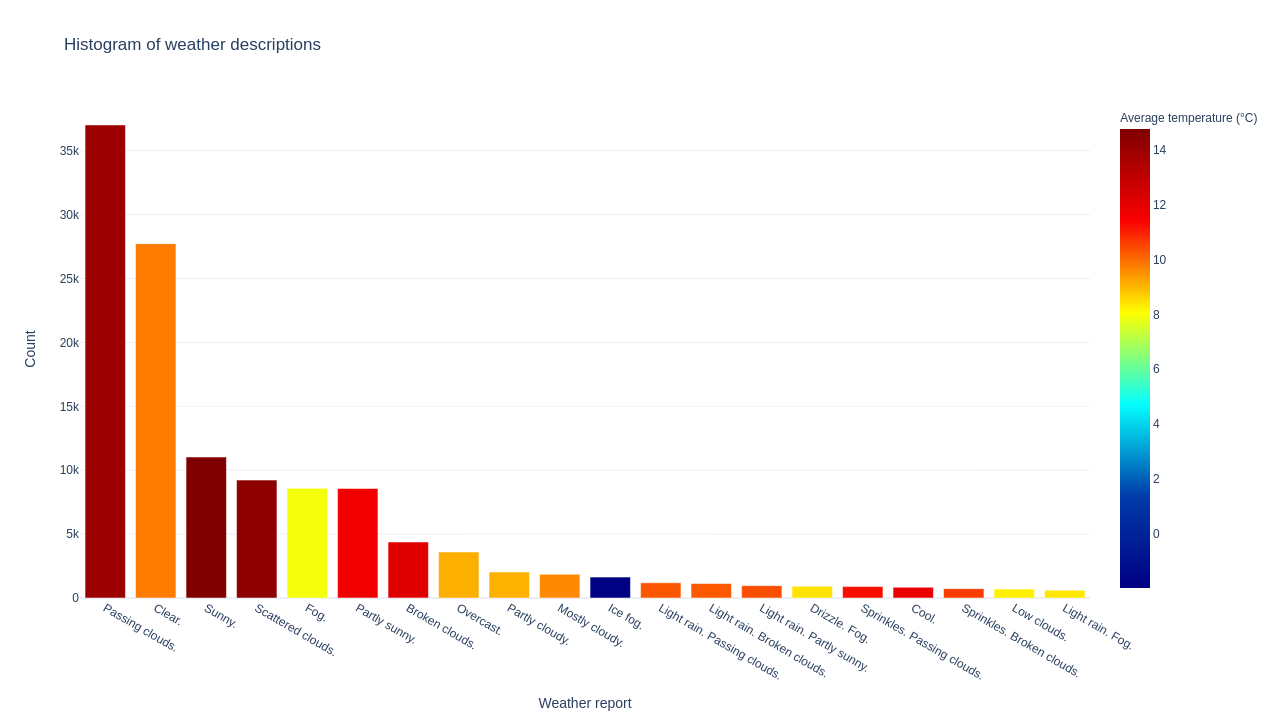

In [110]:
#@title
title = "Histogram of weather descriptions"

count_df = weather["weather"].value_counts().head(20).to_frame().reset_index()
count_df = count_df.rename(columns = {"index":"weather", "weather":"count"})
mean_df = weather.groupby("weather", as_index=False).mean()
merged_df = pd.merge(count_df, mean_df, on="weather")

fig = px.bar(merged_df,
                x="weather", y="count", 
                color="temp", 
                template="plotly_white", title=title,
                color_continuous_scale=px.colors.sequential.Jet
             )
fig.update_xaxes(title_text="Weather report")
fig.update_yaxes(title_text="Count")
fig.update_layout(coloraxis_colorbar_title='Average temperature (°C)')
title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

##Scatter plot of the temperatures (°C) with respect to the feature-engineered clearness score (%). 

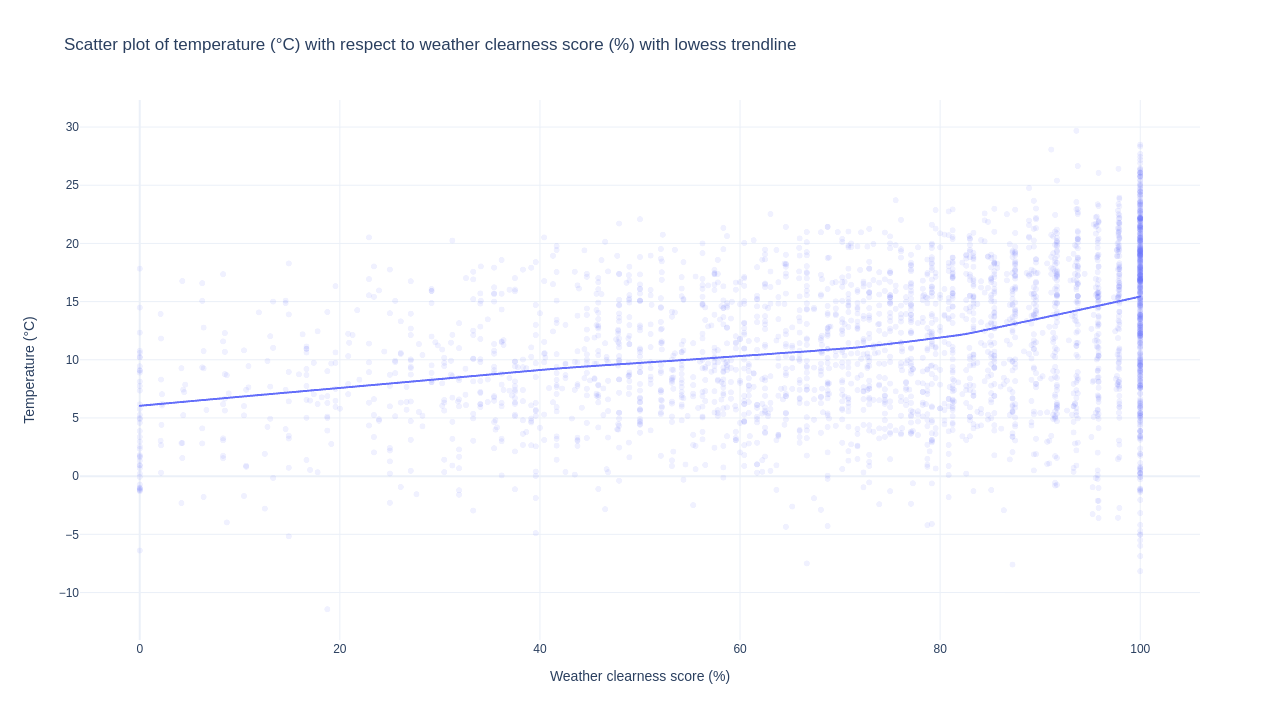

In [111]:
#@title
title = "Scatter plot of temperature (°C) with respect to weather clearness score (%) with lowess trendline"
fig = px.scatter(daily_weather, title=title,
                 x="is_clear", y="temp",
                 template="plotly_white",
                 trendline="lowess",
                #  color="daily_generated_energy",
                 opacity=0.1,
                 color_continuous_scale=px.colors.sequential.Bluered
                 )

fig.update_xaxes(title_text="Weather clearness score (%)")
fig.update_yaxes(title_text="Temperature (°C)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

##The seasonal decompose of monthly average temperatures can be seen on the plot. The trendline shows slightly increasing temperatures over the year.

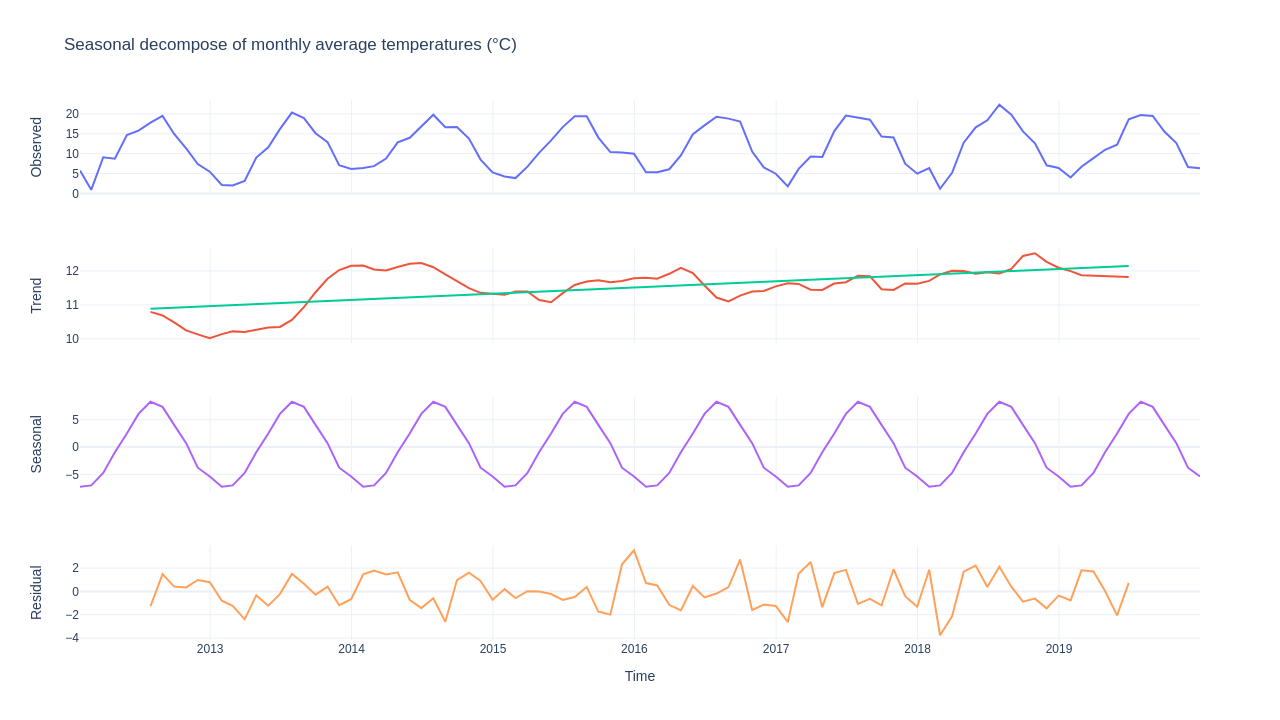

In [112]:
#@title
title = "Seasonal decompose of monthly average temperatures (°C)"
helper = weather.set_index("datetime").groupby(pd.Grouper(freq='M')).mean()
date_axis = helper.index

result = seasonal_decompose(helper["temp"],
                            model='additive',
                            )

fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=date_axis, y=result.observed),
              row=1, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.trend),
              row=2, col=1)

y = result.trend.dropna().values
x = np.arange(len(y))
X, Y = x.reshape(-1,1), y.reshape(-1,1)
fig.add_trace(go.Scatter(x=date_axis[6:],
                         y=LinearRegression().fit(X, Y).predict(X).flatten()),
              row=2, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.seasonal),
              row=3, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.resid),
              row=4, col=1)

fig.update_xaxes(title_text="Time", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

fig.update_layout(
    # height=600, 
    # width=800,
    title_text=title, 
    template="plotly_white",
    showlegend=False,
    
)

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))
    


##Seasonal decompose of monthly average wind speed in km/h. The trendline shows slightly decreasing wind speeds over the year. Notice: the most windy month is december in Antwerp.

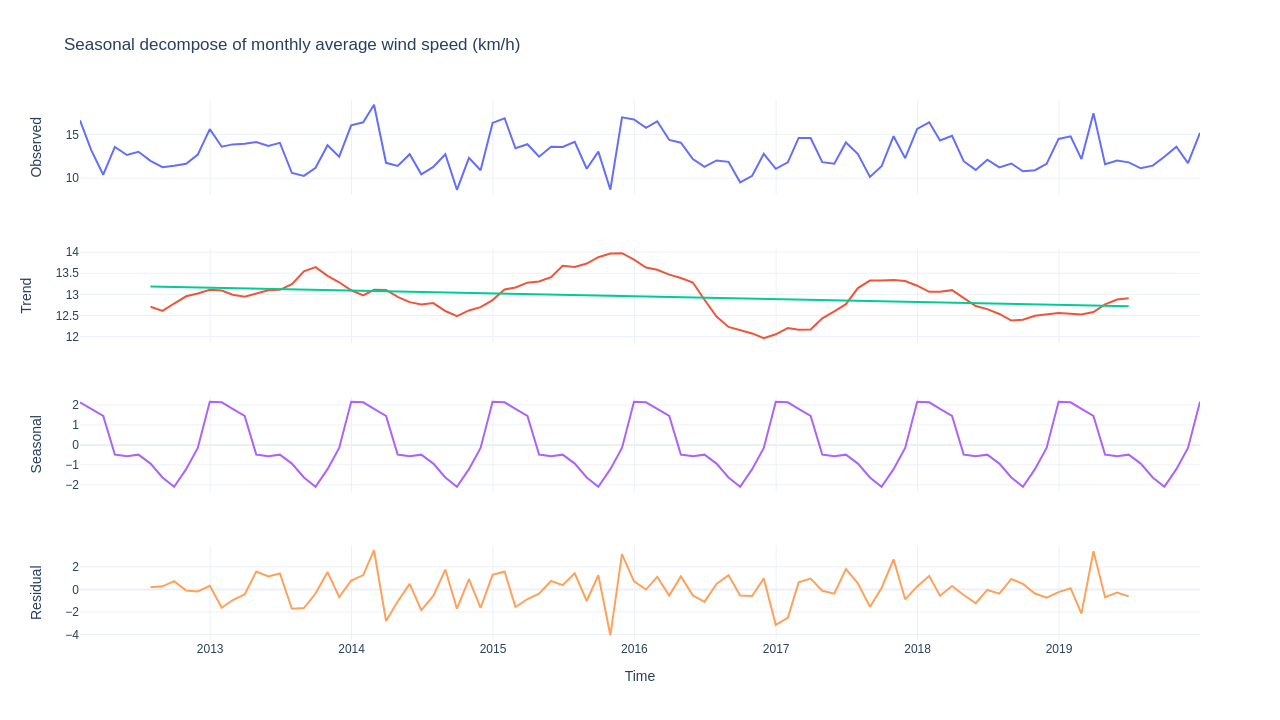

In [113]:
#@title
title = "Seasonal decompose of monthly average wind speed (km/h)"
helper = weather.set_index("datetime").groupby(pd.Grouper(freq='M')).mean()
date_axis = helper.index

result = seasonal_decompose(helper["wind"],
                            model='additive',
                            )

fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=date_axis, y=result.observed),
              row=1, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.trend),
              row=2, col=1)

y = result.trend.dropna().values
x = np.arange(len(y))
X, Y = x.reshape(-1,1), y.reshape(-1,1)
fig.add_trace(go.Scatter(x=date_axis[6:],
                         y=LinearRegression().fit(X, Y).predict(X).flatten()),
              row=2, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.seasonal),
              row=3, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.resid),
              row=4, col=1)

fig.update_xaxes(title_text="Time", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

fig.update_layout(
    # height=600, 
    # width=800,
    title_text=title, 
    template="plotly_white",
    showlegend=False,
    
)

title = title.replace(" ", "_").replace("/", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))
    


##The seasonal decompose of monthly average clearness score shows a slight increase in visibility.

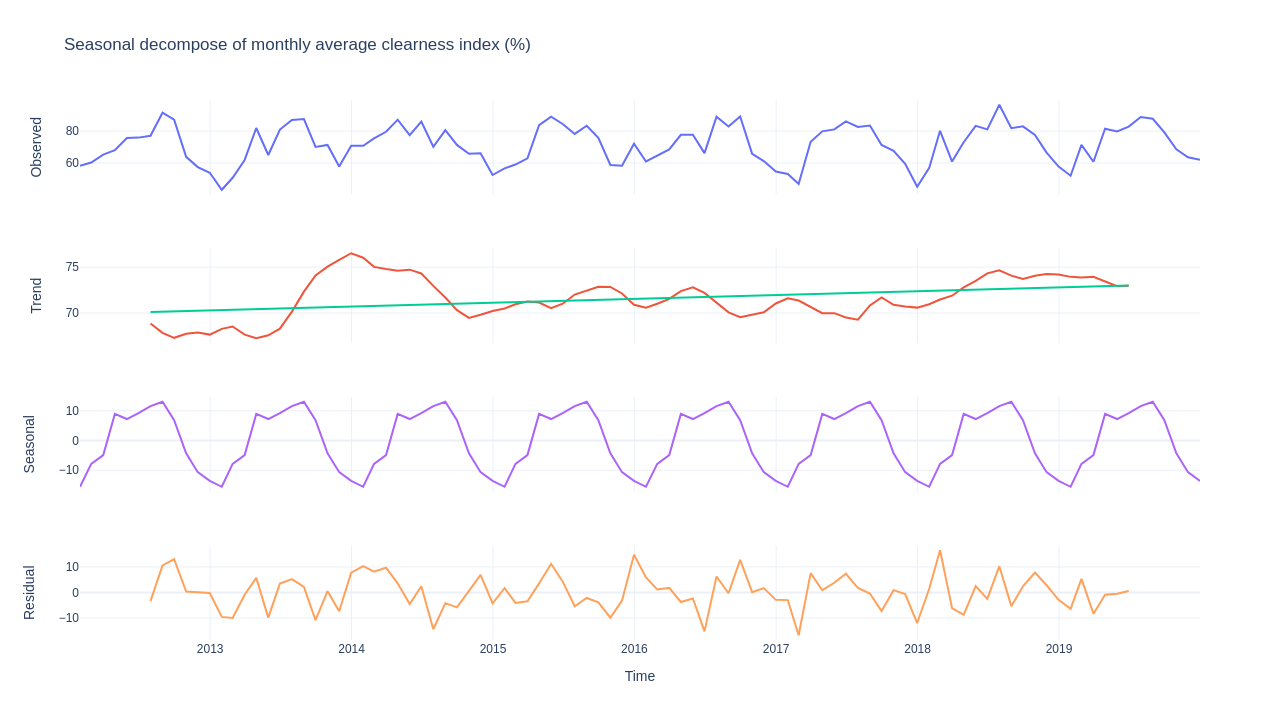

In [114]:
#@title
title = "Seasonal decompose of monthly average clearness index (%)"
helper = daily_weather.set_index("date").groupby(pd.Grouper(freq='M')).mean()
date_axis = helper.index

result = seasonal_decompose(helper["is_clear"],
                            model='additive',
                            )

fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=date_axis, y=result.observed),
              row=1, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.trend),
              row=2, col=1)

y = result.trend.dropna().values
x = np.arange(len(y))
X, Y = x.reshape(-1,1), y.reshape(-1,1)
fig.add_trace(go.Scatter(x=date_axis[6:],
                         y=LinearRegression().fit(X, Y).predict(X).flatten()),
              row=2, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.seasonal),
              row=3, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.resid),
              row=4, col=1)

fig.update_xaxes(title_text="Time", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

fig.update_layout(
    # height=600, 
    # width=800,
    title_text=title, 
    template="plotly_white",
    showlegend=False,
    
)

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))
    


##The histogram of the tempareture values colored by months. Summer months are represented with red.

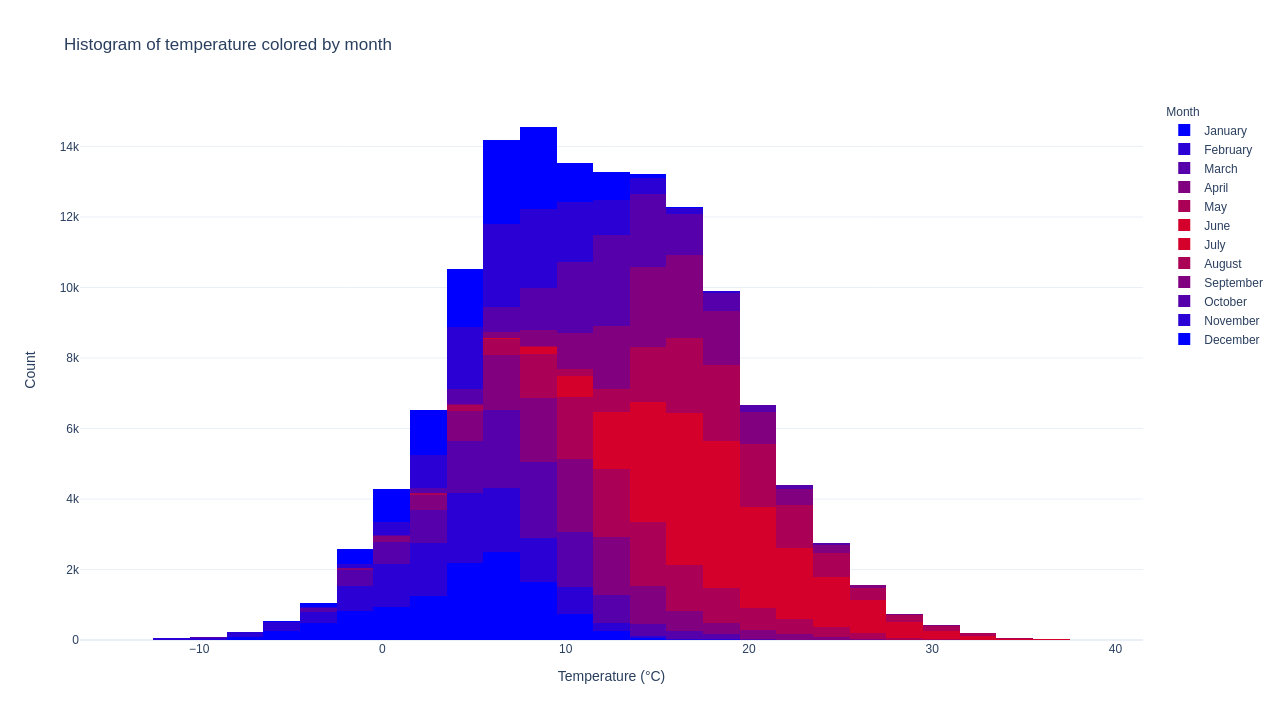

In [115]:
#@title
title = "Histogram of temperature colored by month"

month_colors = [plotly.colors.find_intermediate_color(
        lowcolor='rgb(0,0,255)', highcolor='rgb(255,0,0)',
        intermed=1/6*i,
        colortype="rgb") for i in range(6)]

month_colors.extend(month_colors[::-1])

fig = px.histogram(weather, x="temp", nbins = 30, 
                   color="month_name", 
                   template="plotly_white", title=title,
                   color_discrete_sequence=month_colors,
                   )

fig.update_xaxes(title_text="Temperature (°C)")
fig.update_yaxes(title_text="Count")
fig.update_layout(legend_title_text='Month')


title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

##Normalized histogram of temperatures colored by years. Notice the extreme temperatures: really cold temperatures occured only in 2012 and 2013, quite hot temperatures occured only in 2018 and 2019. Altough the time span is quite small, this is one of the sign of global warming.

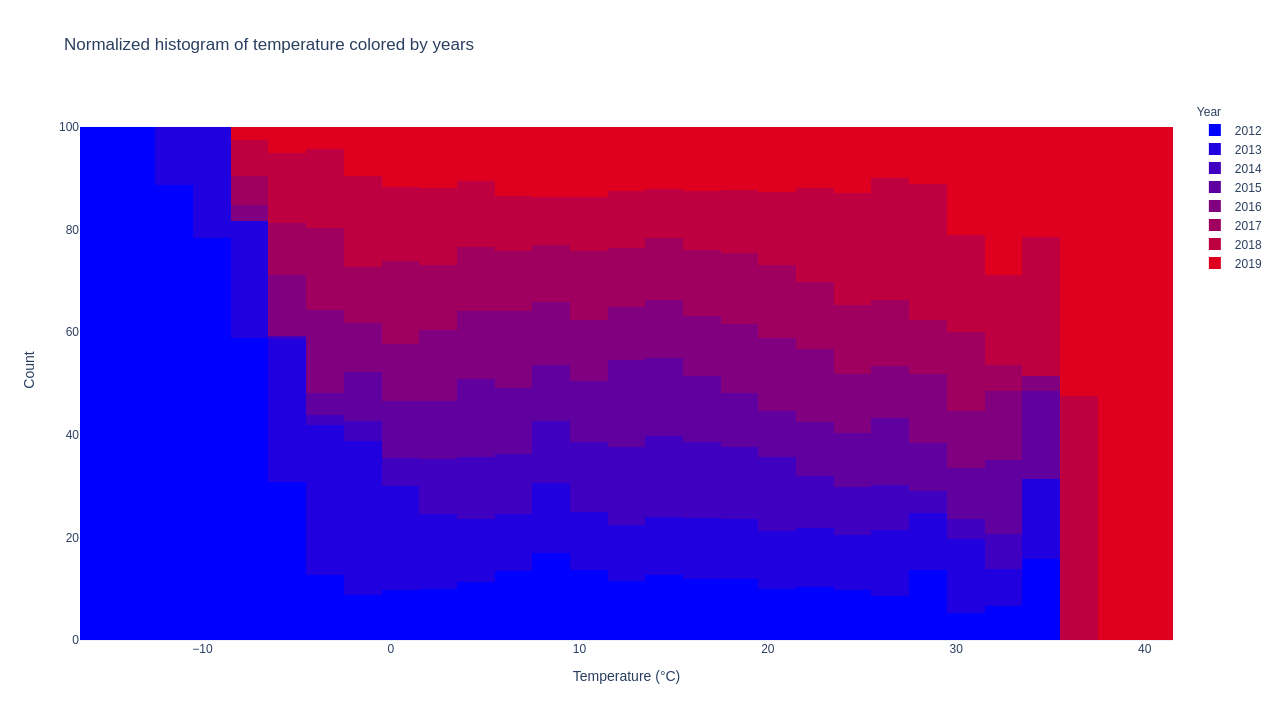

In [116]:
#@title
title = "Normalized histogram of temperature colored by years"

month_colors = [plotly.colors.find_intermediate_color(
        lowcolor='rgb(0,0,255)', highcolor='rgb(255,0,0)',
        intermed=1/8*i,
        colortype="rgb") for i in range(8)]

fig = px.histogram(weather, x="temp", nbins = 30, 
                   color="year", 
                   template="plotly_white", title=title,
                   barnorm='percent',
                   color_discrete_sequence=month_colors,
                   )
fig.update_xaxes(title_text="Temperature (°C)")
fig.update_yaxes(title_text="Count")
fig.update_layout(legend_title_text='Year')

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

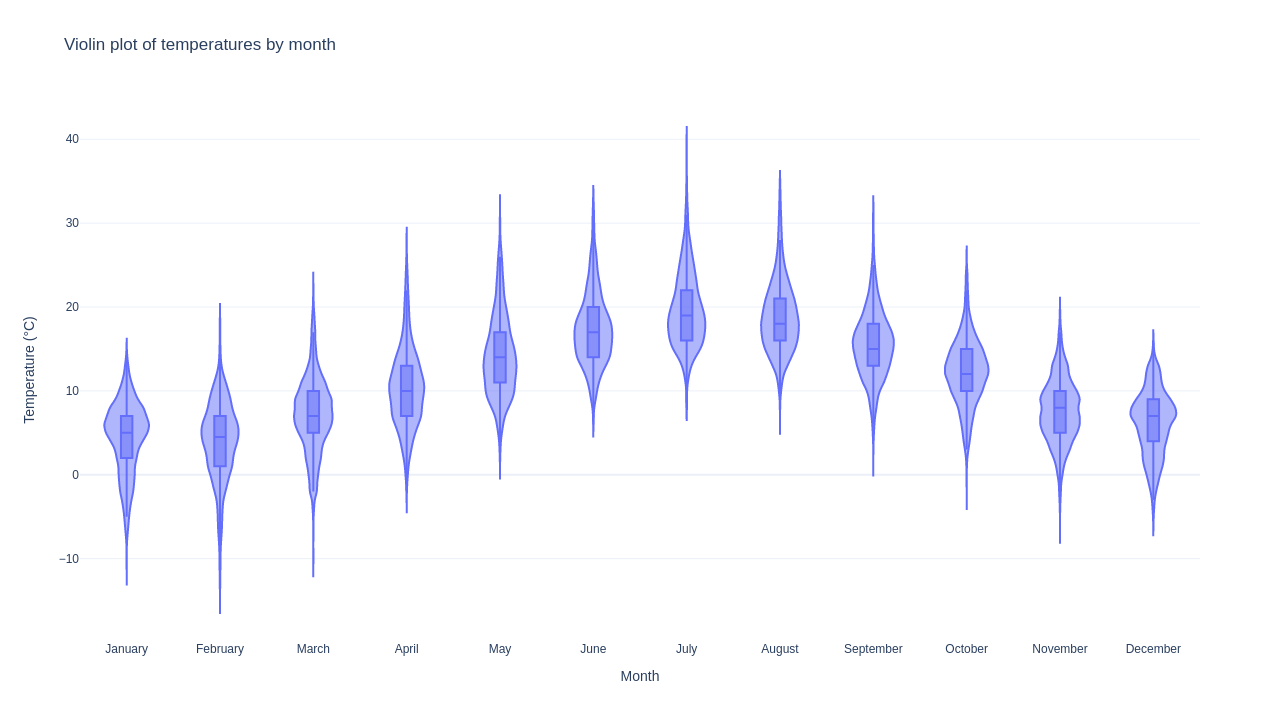

In [117]:
#@title
title = "Violin plot of temperatures by month"

fig = px.violin(weather, x="month_name", y="temp", 
                template="plotly_white", title=title, 
                box=True, points=False)
# fig = px.strip(weather, x="month", y="daily_energy", 
#                 template="plotly_white", title=title, 
#                 )
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Temperature (°C)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


##Scatter plot of temperature and wind. High winds speeds mostly occur in mild weather (wind is caused by difference of temperatures in some atmospheric region)

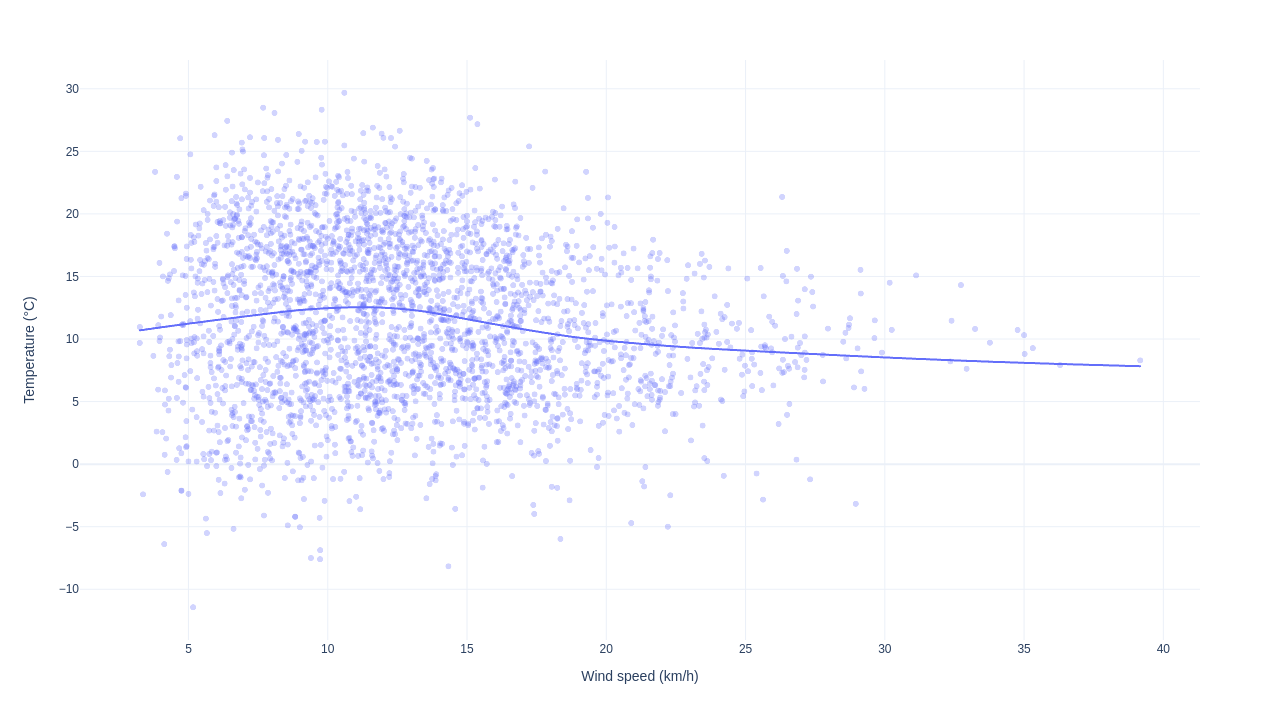

In [118]:
#@title
title = "Scatter plot of temperatures vs wind speed with lowess trendline"

# jittered = weather.copy()
# jittered["wind"] += np.random.normal(0, 0.1, len(jittered["wind"]))

fig = px.scatter(daily_weather,
                 x="wind", y="temp",
                 template="plotly_white",
                 trendline="lowess",
                 opacity=0.3
                 )
fig.update_xaxes(title_text="Wind speed (km/h)")
fig.update_yaxes(title_text="Temperature (°C)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

#Other plots created during our experiments
(redundant, not so useful or interesting plots, but it is not worth deleting them)

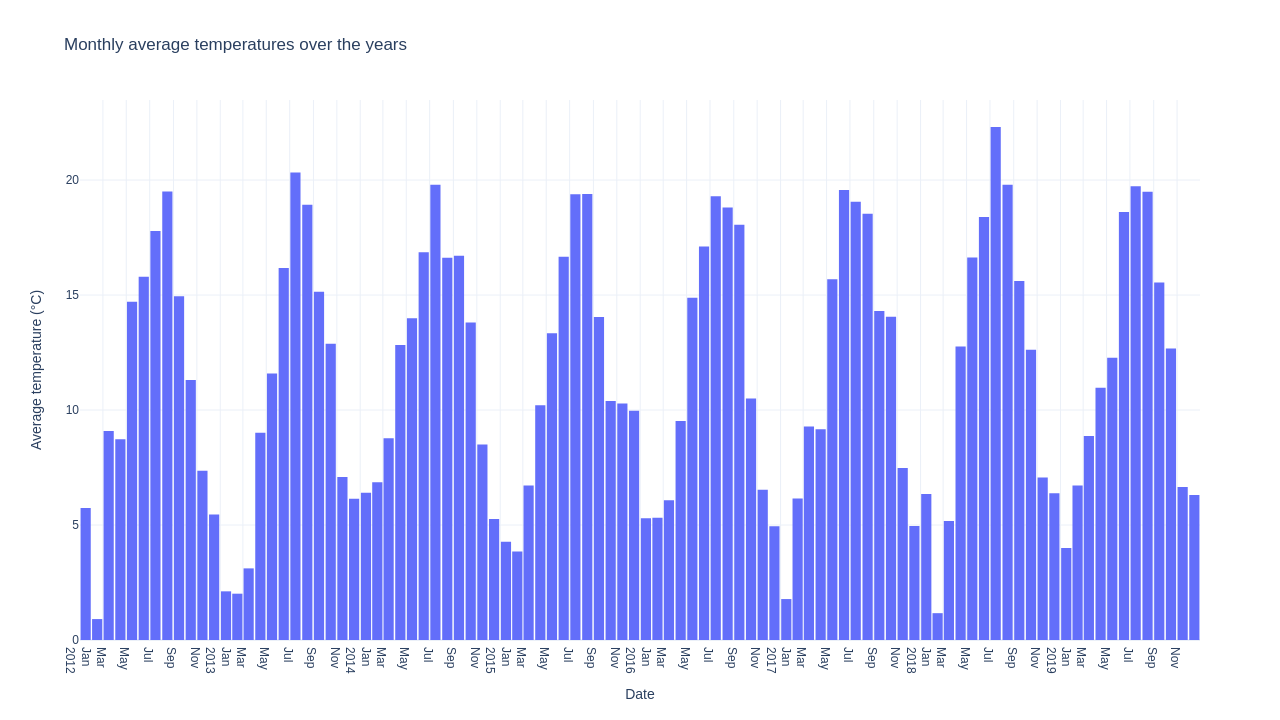

In [119]:
#@title
title = "Monthly average temperatures over the years"

fig = px.histogram(weather,
                   x="date", y="temp",
                   histfunc="avg",
                   template="plotly_white", title=title)
fig.update_traces(xbins_size="M1")
fig.update_xaxes(showgrid=True, dtick="M2", tickformat="%b\n%Y")
fig.update_layout(bargap=0.1)
# fig.add_trace(go.Scatter(mode="markers", x=weather["date"], y=weather["daily_energy"], name="daily"))

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Average temperature (°C)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


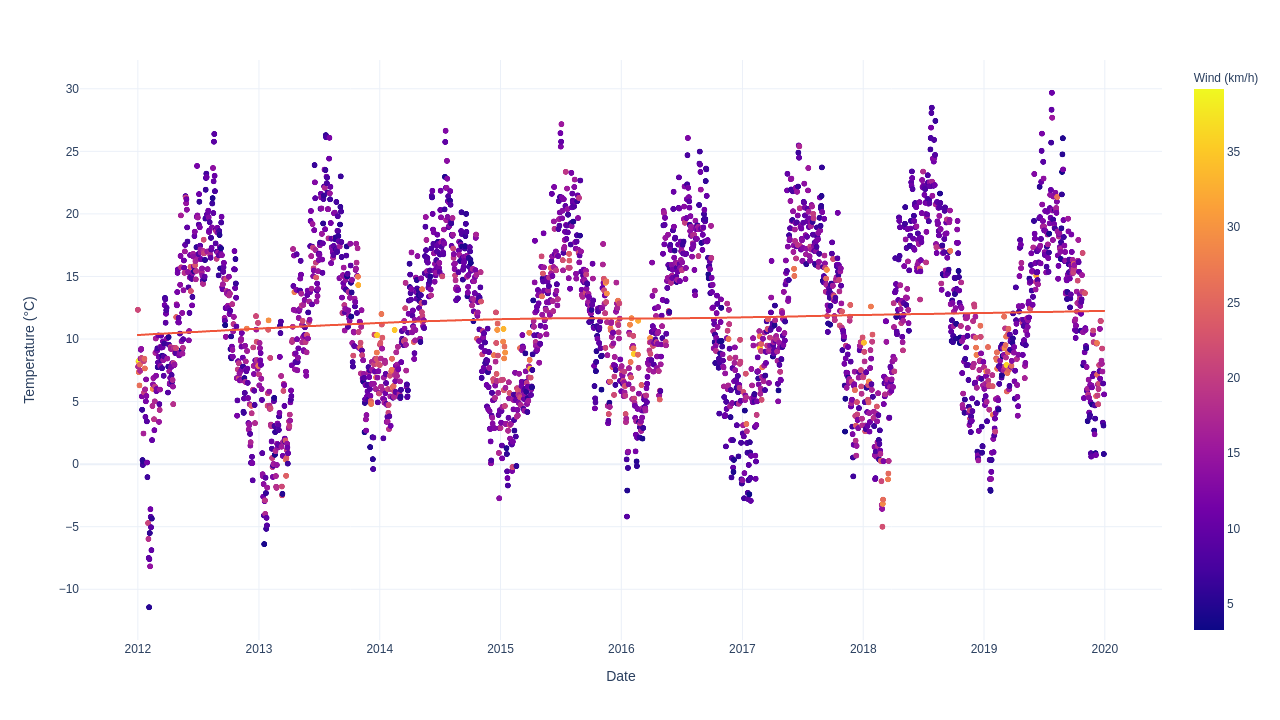

In [120]:
#@title

daily_weather = weather.resample('D', on='datetime').mean().reset_index()

title = "Scatter plot of temperature vs date with lowess trendline"
fig = px.scatter(daily_weather,
                 x="datetime", y="temp",
                 template="plotly_white",
                 trendline="lowess",
                 color = "wind"
                 )

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Temperature (°C)")
fig.update_layout(coloraxis_colorbar_title='Wind (km/h)')

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

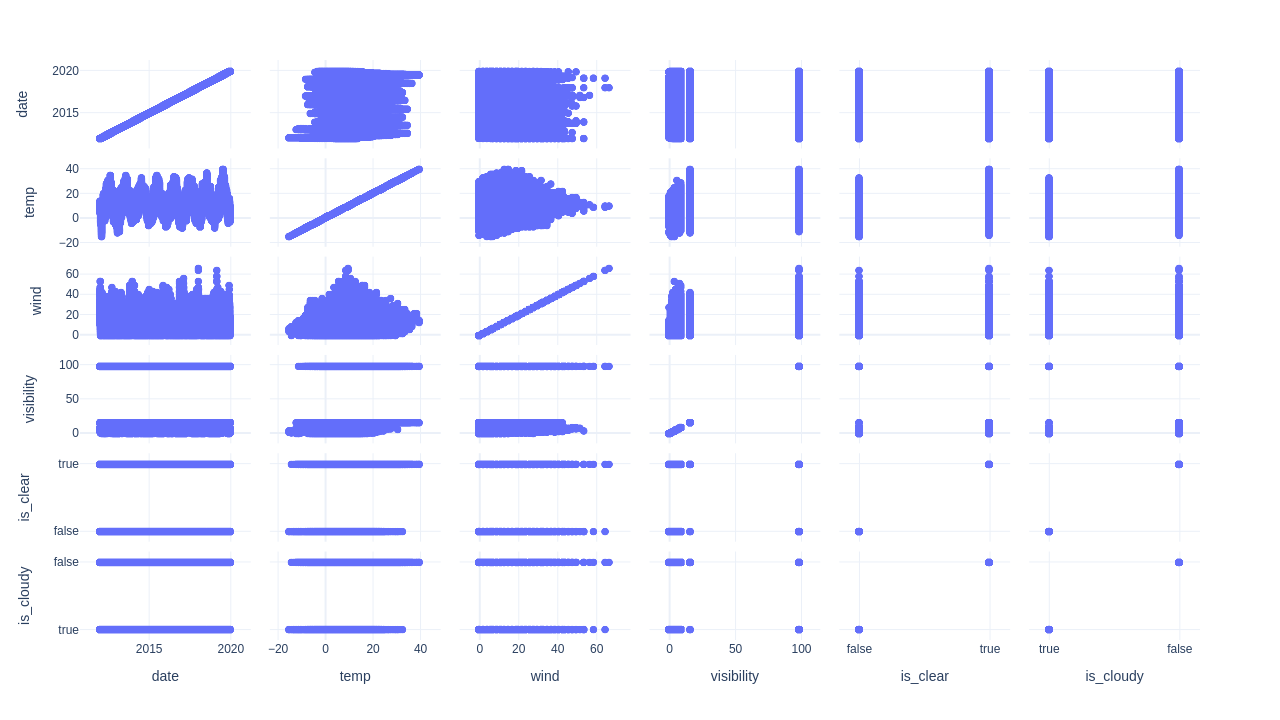

In [121]:
fig = px.scatter_matrix(weather, dimensions=["date", "temp", "wind", "visibility", "is_clear", "is_cloudy"], template="plotly_white")

fig.write_html("scatter_matrix.html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

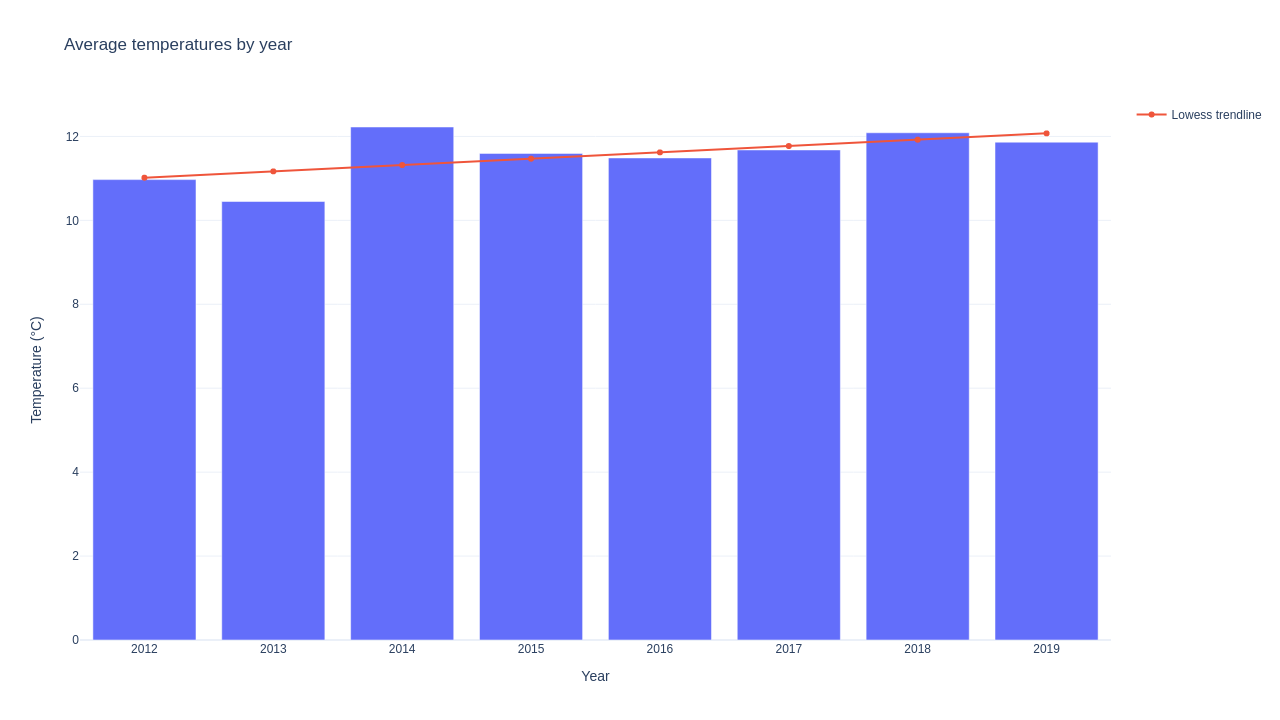

In [122]:
#@title
title = "Average temperatures by year"
fig = px.bar(weather.groupby("year", as_index=False).mean(), 
             x="year", y="temp", 
             template="plotly_white", title=title,
             )

help_fig = px.scatter(
    weather.groupby("year", as_index=False).mean(),
     x="year", y="temp", trendline="ols")
x_trend = help_fig["data"][1]['x']
y_trend = help_fig["data"][1]['y']

fig.add_trace(go.Line(x=x_trend, y=y_trend, name="Lowess trendline"))
fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Temperature (°C)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


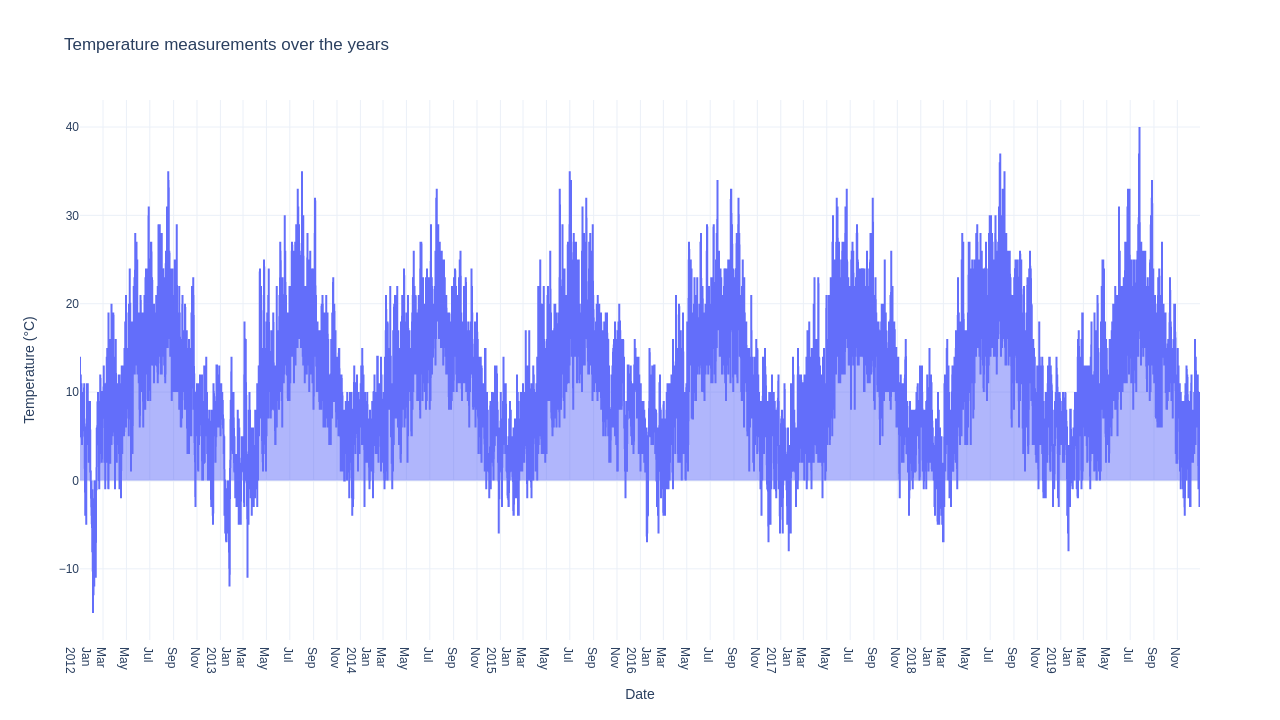

In [123]:
#@title
title = "Temperature measurements over the years"
fig = px.area(weather,
              x="date", y="temp",
              template="plotly_white", title=title)
fig.update_xaxes(
    dtick="M2",
    tickformat="%b\n%Y")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Temperature (°C)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


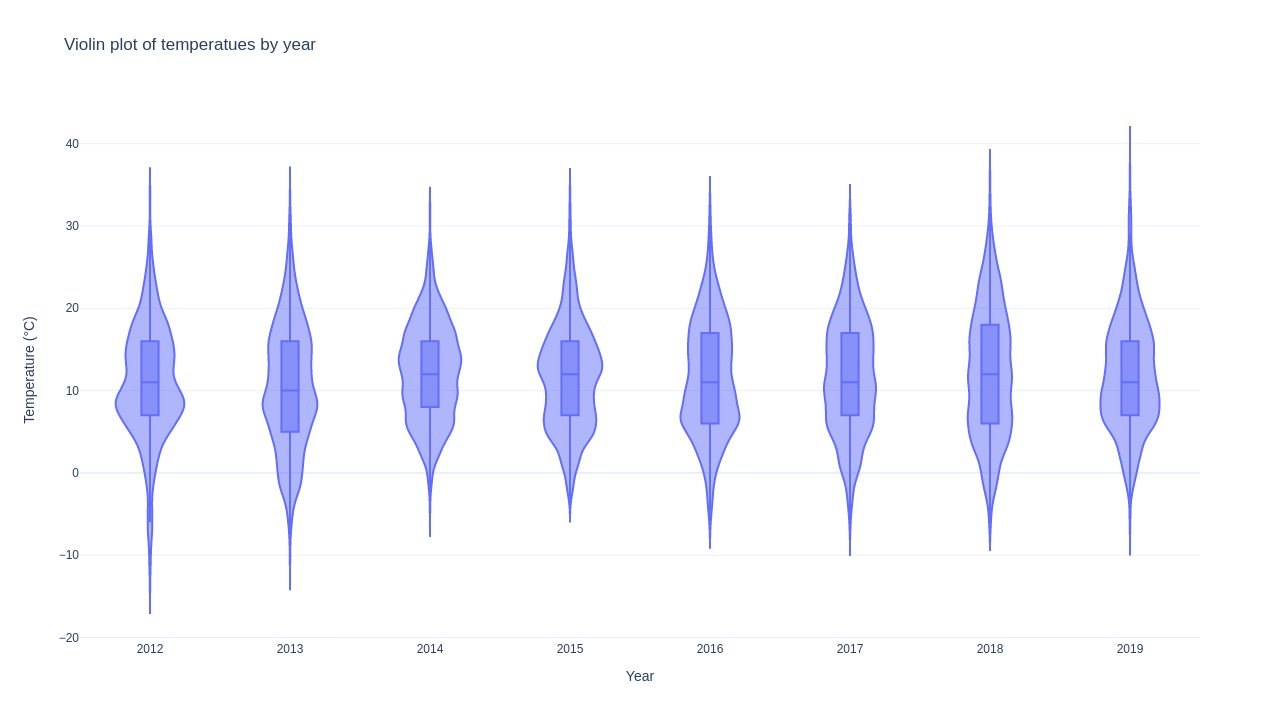

In [124]:
#@title
title = "Violin plot of temperatues by year"

fig = px.violin(weather, x="year", y="temp", 
                template="plotly_white", box=True, points=False, 
                title=title)

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Temperature (°C)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


In [125]:
## download all generated interactive html file
# !zip -q -r charts.zip *html
# from google.colab import files
# files.download("charts.zip")